In [45]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs

# 한국 상장된 주식 리스트 -> NAVER

In [46]:
stocklist_df = fdr.StockListing('KRX')

In [47]:
ticker = stocklist_df[stocklist_df['Name'] == 'NAVER']

In [48]:
ticker

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
1338,035420,KOSPI,NAVER,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업",포털 서비스 및 온라인 광고,2008-11-28,12월,최수연,http://www.navercorp.com,경기도


# 위에서 찾은 종목코드로 데이터 불러오기

In [49]:
ns = fdr.DataReader('035420', '2020')

In [50]:
ns

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,187500,188000,182000,182500,300640,-0.021448
2020-01-03,185000,186000,180500,181500,454492,-0.005479
2020-01-06,180000,182000,178000,180500,287970,-0.005510
2020-01-07,182500,187000,181500,187000,328624,0.036011
2020-01-08,182000,183500,179000,183000,820867,-0.021390
...,...,...,...,...,...,...
2022-10-13,160500,161000,155000,158500,1487183,-0.021605
2022-10-14,163500,168500,163000,165500,1568930,0.044164
2022-10-17,162500,168000,160500,167000,1436527,0.009063


# train / test 데이터 나누기

In [51]:
y_train = ns['Close'][:int(0.7*len(ns))]
y_test = ns['Close'][int(0.7*len(ns)):]

<AxesSubplot:xlabel='Date'>

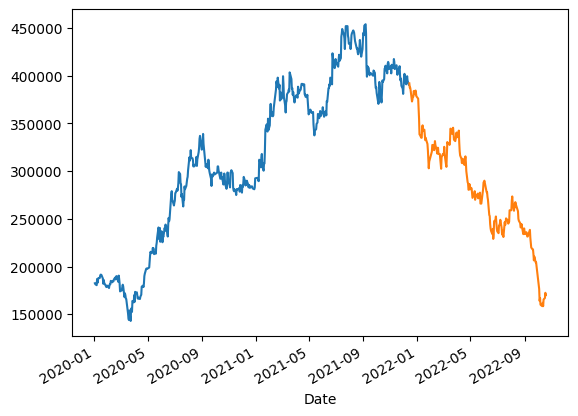

In [52]:
y_train.plot()
y_test.plot()

# 차분 차수 구하기
- kpss / adf 둘 중 큰 값 나오는 수만큼 차분해주기

In [53]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
print(kpss_diffs, adf_diffs)

1 1


In [54]:
from pmdarima.arima import auto_arima

model = auto_arima(y = y_train,
                  d = 1,
                  start_p = 0,
                  max_p = 3,
                  start_q = 0,
                  max_q = 3,
                  m = 1, # 4 : 분기별 12 : 월별 1 : default 값
                  seasonal = False,
                  stepwise = True,
                  trace = True 
                  )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9898.136, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9900.010, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9900.006, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9897.999, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9901.893, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.410 seconds


# 생성된 model 확인 (summary)
- Ljung-Box의 Prob = 0.76 => 0.5보다 크므로 정상성 띄고 있다고 할 수 있음
- Jarque-Bera의 Prob = 0.00 => 0.5보다 작으므로 정규성 따르지 않음
- Heteroskedasticity = 0.00 => 0.5보다 작으므로 이분산 아니고 등분산성
- 즉, 정규성은 따르지 않지만 등분산성은 가짐

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  483
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4947.999
Date:                Wed, 19 Oct 2022   AIC                           9897.999
Time:                        14:11:34   BIC                           9902.177
Sample:                             0   HQIC                          9899.641
                                - 483                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.821e+07   2.08e+06     23.126      0.000    4.41e+07    5.23e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               119.21
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

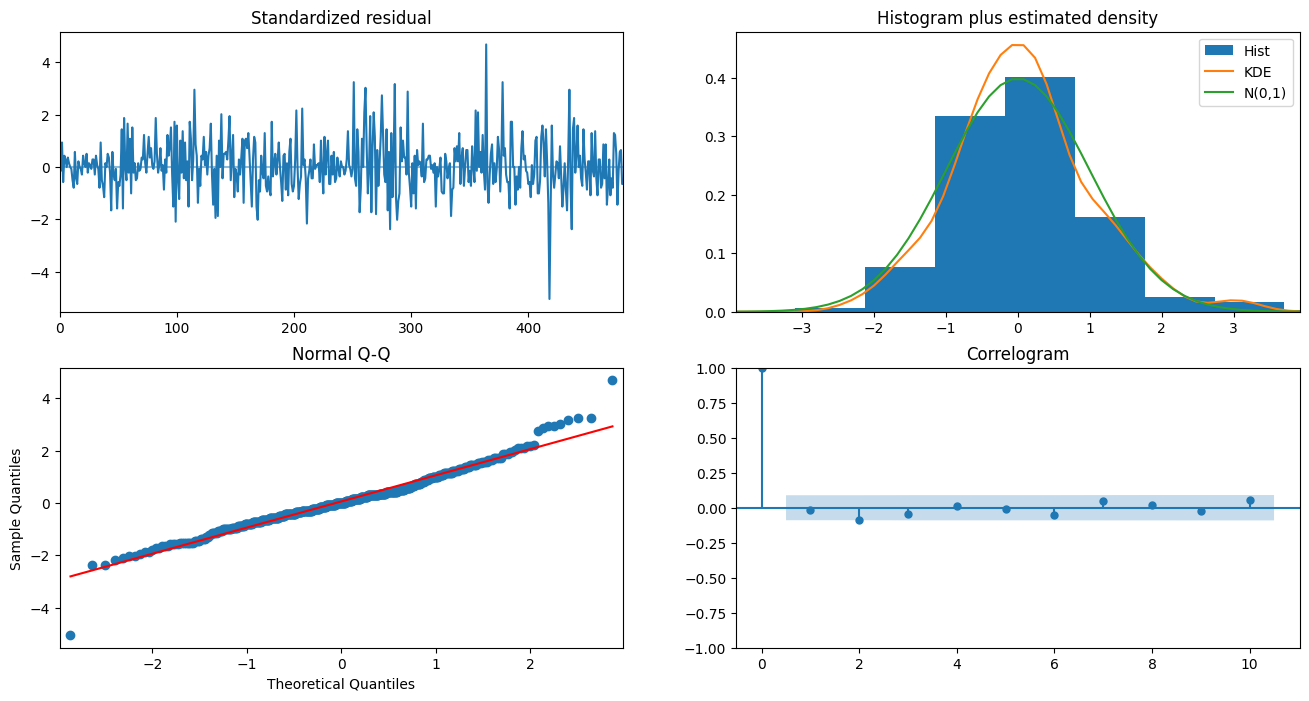

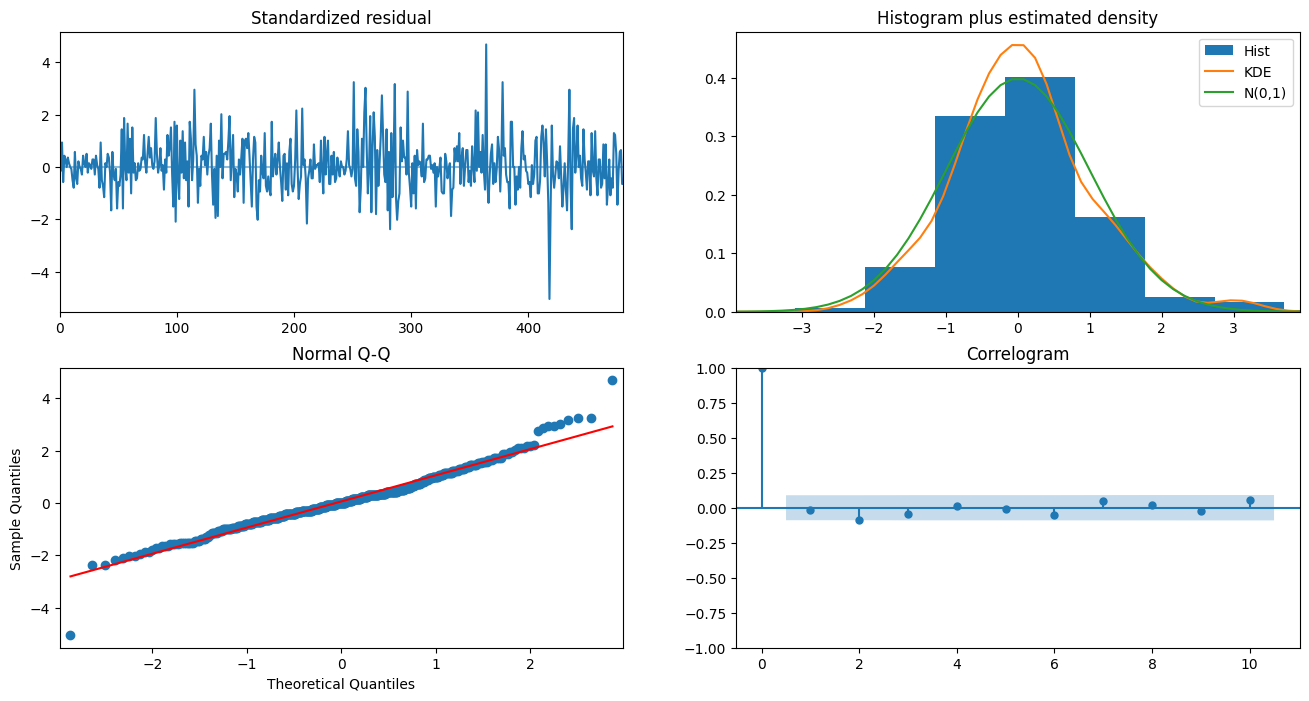

In [56]:
model.plot_diagnostics(figsize=(16,8))

# 예측 

## 예측 - 예측 값이 모두 한 값으로 나옴 

In [63]:
y_test.index

DatetimeIndex(['2021-12-14', '2021-12-15', '2021-12-16', '2021-12-17',
               '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-24', '2021-12-27',
               ...
               '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-11',
               '2022-10-12', '2022-10-13', '2022-10-14', '2022-10-17',
               '2022-10-18', '2022-10-19'],
              dtype='datetime64[ns]', name='Date', length=208, freq=None)

c:\users\qkrtj\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


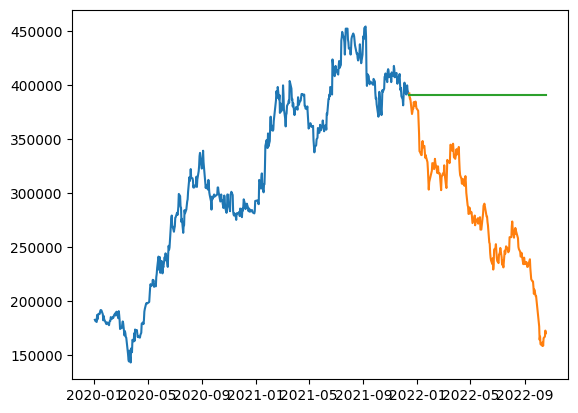

In [74]:
y_pred = model.predict(n_periods=len(y_test))
y_pred = pd.DataFrame(list(y_pred), index=y_test.index, columns=['Prediction'])

plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Prediction')

plt.show()

## 예측 - 전 날 값으로 예측 값 나옴

In [79]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])
#     print(result)
    
forecast_one_step()

c:\users\qkrtj\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


(390500.0, [376890.6946121189, 404109.3053878811])

In [81]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    model.update(new_ob)

c:\users\qkrtj\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [82]:
pd.DataFrame({'test':y_test, 'pred':y_pred})

,test,pred
Date,,
2021-12-14,392000,390500.0
2021-12-15,387500,392000.0
2021-12-16,387500,387500.0
2021-12-17,384500,387500.0
2021-12-20,373000,384500.0
...,...,...
2022-10-13,158500,162000.0
2022-10-14,165500,158500.0
2022-10-17,167000,165500.0
